# Clustering the Alanine Dipeptide using Meta Dynamics Weights

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from shapeGMMTorch import torch_sgmm
import torch

/Users/mmccull/opt/anaconda3/envs/nomkl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read trajectory

In [2]:
prmtopFileName = "adp_amber99_T300_2dMetad.gro"
trajFileName = "adp_amber99_T300_2dMetad.trr"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('name C N CA')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 22
Number of frames in trajectory: 5001
Number of atoms in selection: 5


## Perform Cross Validation with Uniform Weights

In [3]:
# scripts contains a built-in CV routine
from shapeGMMTorch import scripts

Here we will perform a cluster scan assuming each frame has the same weight.  This is exactly what we did in the other notebook.

In [4]:
# define cluster array
cluster_array = np.arange(1,7,1).astype(int)

In [5]:
# uniform weights
train, cv = scripts.cross_validate_cluster_scan(traj_data, 2000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 2000
Number of frames to predict each model: 3001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              28.073          47.700
              1               1               2              28.073          48.259
              1               1               3              28.073          47.514
              1               1               4              28.073          47.551
              1               1               5              28.073          47.468
              1               2               1              28.455          58.952
              1               2               2              34.791          57.804
              1               2               3              28.930 

## Perform Cross Validation with MetaD Weights for each Frame

We will read the metadynamics weight from the colvar file.

In [ ]:
# load the weights
frame_weights = np.loadtxt("colvar",comments="#")[:,-1]
print(frame_weights.shape)
print(np.sum(frame_weights))

In [7]:
# CV scan with non-uniform weights
metaD_train, metaD_cv = scripts.cross_validate_cluster_scan(traj_data, 2000, frame_weights = frame_weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 2000
Number of frames to predict each model: 3001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              27.440          51.595
              1               1               2              27.440          51.705
              1               1               3              27.440          51.670
              1               1               4              27.440          51.812
              1               1               5              27.440          51.575
              1               2               1              30.779          63.853
              1               2               2              36.205          60.635
              1               2               3              30.870 

## Perform Cross-Validation with Random Weights for each Frame

In [6]:
# load the weights
random_frame_weights = np.random.rand(frame_weights.shape[0])
random_frame_weights /= np.sum(random_frame_weights)

In [ ]:
# CV scan with non-uniform weights
random_train, random_cv = scripts.cross_validate_cluster_scan(traj_data, 2000, frame_weights = random_frame_weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

### Save and load log likelihood data for quick use

In [9]:
# save data (optional - don't have to do this)
np.savetxt("uniform_frame_weights_ll_train.dat", train)
np.savetxt("uniform_frame_weights_ll_cv.dat", cv)
np.savetxt("metaD_frame_weights_ll_train.dat", metaD_train)
np.savetxt("metaD_frame_weights_ll_cv.dat", metaD_cv)
#np.savetxt("random_frame_weights_ll_train.dat", random_train)
#np.savetxt("random_frame_weights_ll_cv.dat", random_cv)

In [6]:
# load data
# NOTE - only do this if you want to overwrite active arrays
train = np.loadtxt("uniform_frame_weights_ll_train.dat")
cv = np.loadtxt("uniform_frame_weights_ll_cv.dat")
enm_train = np.loadtxt("enm_frame_weights_ll_train.dat")
enm_cv = np.loadtxt("enm_frame_weights_ll_cv.dat")
random_train = np.loadtxt("random_frame_weights_ll_train.dat")
random_cv = np.loadtxt("random_frame_weights_ll_cv.dat")

## Make Log Likelihood vs number of Cluster Plots

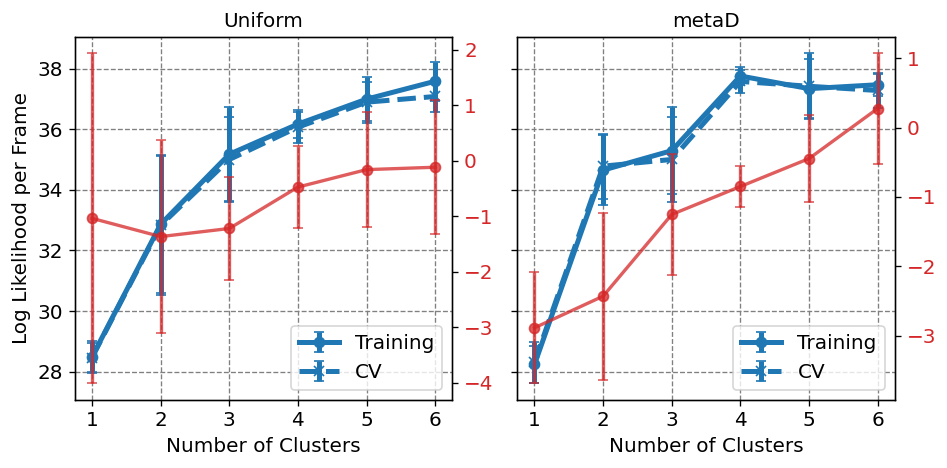

In [11]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch import plots
# also need to load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
fig, ax = plt.subplots(1,2,figsize=(8,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
# Uniform Weights
ax[0].set_title("Uniform",fontsize=12)
plots.plot_log_likelihood_with_dd(ax[0],cluster_array,train,cv,fontsize=12,ylabel1=True,ylabel2=False,xlabel=True)
# ENM Weights
ax[1].set_title("metaD",fontsize=12)
plots.plot_log_likelihood_with_dd(ax[1],cluster_array,metaD_train,metaD_cv,fontsize=12,ylabel1=False,ylabel2=False,xlabel=True)
# Random Weights
#ax[2].set_title("Random",fontsize=12)
#plots.plot_log_likelihood_with_dd(ax[2],cluster_array,random_train,random_cv,fontsize=12,ylabel1=False,ylabel2=True,xlabel=True)
# show plot
plt.tight_layout()
plt.show()

## Fit a $n_{clusters}=2$ object with metaD weights

In [8]:
# fit a shapeGMM object for n=2 with ENM weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_metaD_weights = scripts.sgmm_fit_with_attempts(traj_data, 2, 10, frame_weights,device=torch.device("cpu"))

Number of training frames: 5001
Number of clusters: 2
Number of attempts: 10
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              48.085           8.804
       2              48.076           5.329
       3              48.084           5.691
       4              44.067          23.585
       5              48.085           5.309
       6              48.061           7.176
       7              48.062           8.053
       8              48.084           5.267
       9              44.202          44.612
      10              48.085           8.628
